## Are a single reviewer's scores autocorrelated?  
  
Procedure:
* Plot, for randomly selected (20? 30?) reviewers with over 20 reviews, their consecutive scores against review #.
    * Do the same for another subset's BNM awarding behavior
* Look at average time lag between reviews (i.e. if most reviewers review an album on avg every week, we'd let time lag 1 be equivalent to 7 days)
* Visualize partial autocorrelations to see which lag is appropriate for autocorr calculations
* Compute autocorrelations:
    * For each author, compute autocorrelation using determine time lag
    * Use 1-sample t to see if on avg the autocorrs are significantly diff from 0

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import os
from scipy.signal import savgol_filter
from scipy import stats

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

plt.rcParams['axes.facecolor'] = '0.95'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        db_path = os.path.join(dirname, filename)

# connect to SQL database, create connection object to database
connection = sql.connect(db_path)
print("SQL database connected")

table = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", connection)

reviews = pd.read_sql('SELECT * FROM reviews', connection)
genres = pd.read_sql('SELECT * FROM genres', connection)
connection.close()
print('SQL database connection closed')

SQL database connected
SQL database connection closed


## Cleaning and augmenting data  
We're going to be sorting by review publication date, so as in the EDA let's convert it from str format to unix datetime for ease of use.  
We'll also augment the reviews data with each review's number according to the author's history.

In [2]:
reviews['pub_date'] = pd.to_datetime(reviews.pub_date, format = '%Y-%m-%d')
reviews['unix_time'] = reviews.pub_date.view(np.int64) // 10**9  
"""
 Division by 10^9: 
 We truncate trailing zeros since the int represents seconds elapsed since new year's 1970! 
 However, we leave two trailing zeros (as opposed to dividing by 10^11) since conversion to days later on requires another division by 60*60(*24).

"""

reviews_authns = reviews.copy() # review dataframe, augmented with each review's 'number' i.e. its chronology in author's review history
reviews_authns['review_num'] = pd.Series(index=reviews_authns.index, dtype='int64')
reviews_authns['days_since_prev'] = pd.Series(index=reviews_authns.index, dtype='int64')

for a, rows in reviews_authns.groupby('author'):
    ordered = rows.sort_values(by='unix_time')
    n = ordered.shape[0]
    
    # add review number per author
    nums = list(range(1, n+1))
    reviews_authns.at[rows.index, 'review_num'] = nums
    
    # add days since author's last review
    days = np.zeros(n)
    for i in nums[1:]:
        t_curr = ordered.iloc[i-1].unix_time
        t_prev = ordered.iloc[i-2].unix_time
        days[i-1] = (t_curr - t_prev) / (60*60*24) # convert difference from seconds to days
        
    days[0] = np.nan  # first reviews will not have a 'days since' value
    reviews_authns.loc[ordered.index, 'days_since_prev'] = days

Let's take a coarse look at the average reviewers' scoring behavior over the course of 20 reviews. From the EDA we can see that the median number of reviews that authors write is 10, and the upper quartile starts at 34 reviews. For our purposes, 20 or so reviews will do - we'll randomly choose 5 reviewers with 20 or more reviews from the dataset, then plot against the review number up to 20 their a) scores and b) best new music awards.

In [3]:
over20 = reviews_authns.loc[reviews_authns['review_num'] >= 20]['author']
a_over20 = over20.value_counts().index

revnum = [int(i) for i in range(1, 21)]

random.seed(a=28)
a_rand = random.choices(a_over20, k=5)
a_rand

['rob mitchum',
 'paul thompson',
 'alison fields',
 'tom breihan',
 'larry fitzmaurice']

In [4]:
reviews.columns

Index(['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music',
       'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day',
       'pub_month', 'pub_year', 'unix_time'],
      dtype='object')

Text(0.5, 1.0, 'Author BNM awarding behavior over first 20 reviews')

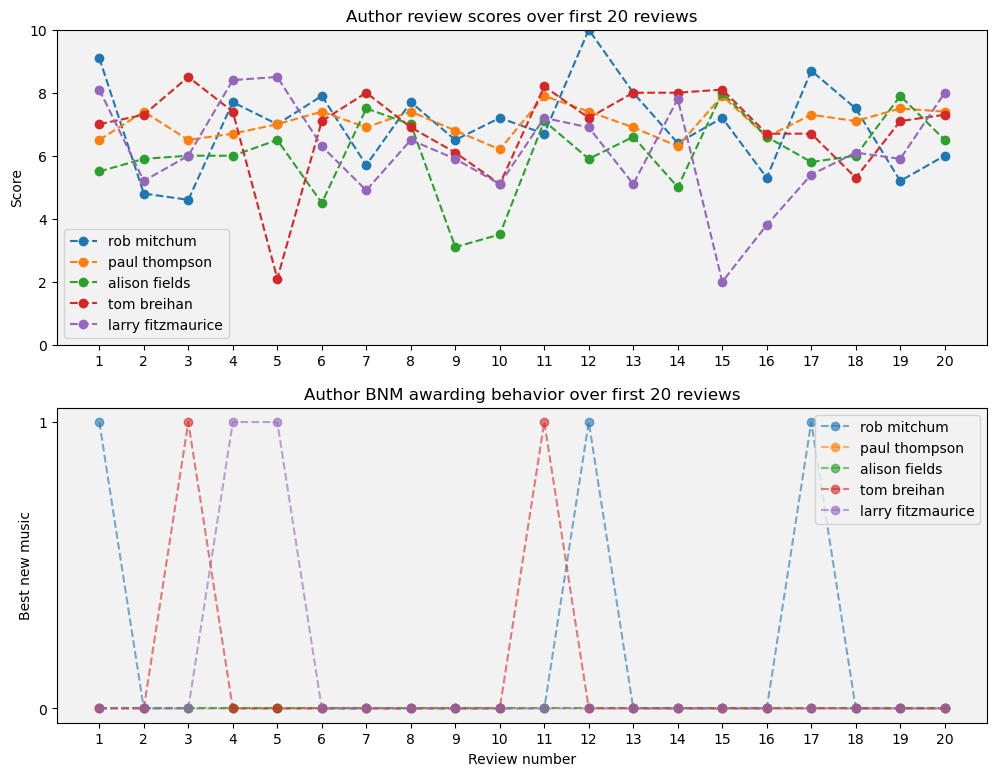

In [5]:
fig, ax = plt.subplots(2, figsize=(12,9))

# plot the authors' scores over 20 reviews on first plot
# plot bnm awarding behavior over same on second plot
for author in a_rand:
    temp_auths = reviews_authns.loc[(reviews_authns['author']==author) & (reviews_authns['review_num']<= 20)]
    temp_scores = temp_auths['score']
    temp_bnm = temp_auths['best_new_music']
    
    ax[0].plot(revnum, temp_scores, '--o', label=author)
    ax[1].plot(revnum, temp_bnm, '--o', alpha=0.6, label=author)
    
ax[0].set_xticks(revnum)
ax[0].set_ylim([0,10])
ax[0].legend(loc='best')
ax[0].set(ylabel='Score')
ax[0].set_title('Author review scores over first 20 reviews')

ax[1].set_xticks(revnum)
ax[1].set_yticks([0,1])
ax[1].legend(loc='best')
ax[1].set(xlabel='Review number', ylabel='Best new music')
ax[1].set_title('Author BNM awarding behavior over first 20 reviews')